Training class counts: Counter({'glass': 999, 'paper': 727, 'cardboard': 618, 'plastic': 591, 'trash': 525, 'metal': 525})
Test class counts: Counter({'glass': 428, 'paper': 311, 'cardboard': 264, 'plastic': 252, 'metal': 225, 'trash': 224})


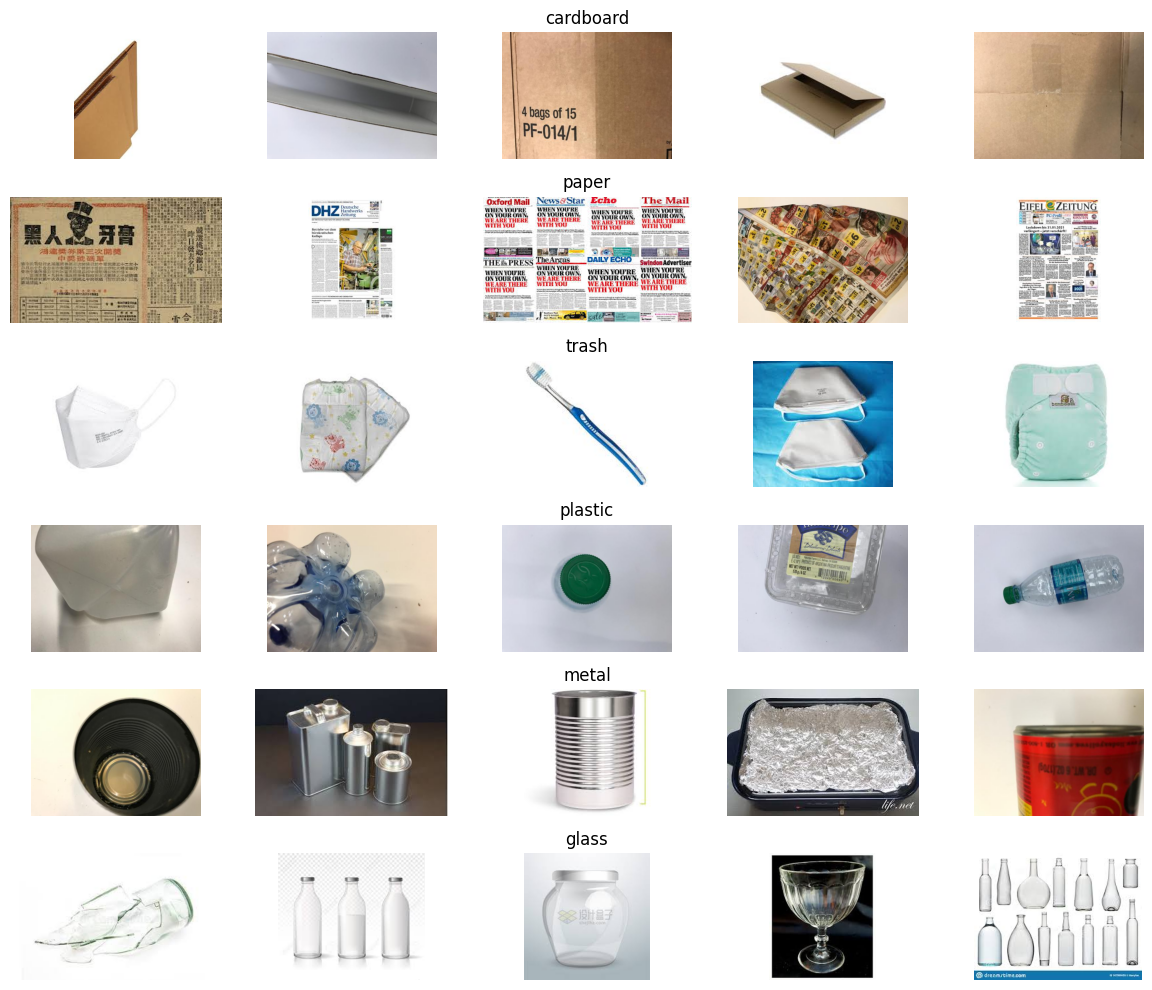

Image width range: 51 - 512
Image height range: 100 - 400


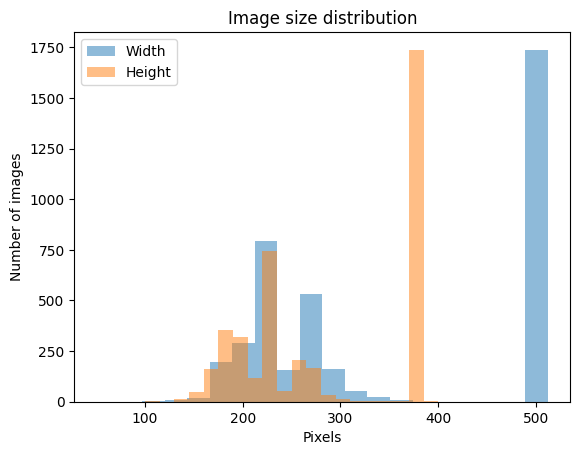

Color channels distribution: Counter({'RGB': 3973, 'P': 12})


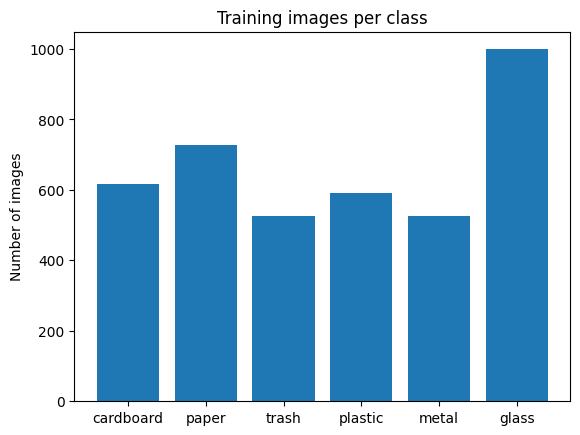

In [2]:
# EDA

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from pathlib import Path
from PIL import Image
import random
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

data_dir = Path(os.getenv("PROJECT_DIR")) / os.getenv("DATA_DIR")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

# Helper function to extract class from filename
def get_class(file_path):
    return file_path.name.split("_")[1]  # e.g., 'train_cardboard_014.jpg' -> 'cardboard'

# ----------------------------
# 1️⃣ Class counts
# ----------------------------
train_files = list(train_dir.glob("*.jpg"))
train_classes = [get_class(f) for f in train_files]
train_counts = Counter(train_classes)
print("Training class counts:", train_counts)

test_files = list(test_dir.glob("*.jpg"))
test_classes = [get_class(f) for f in test_files]
test_counts = Counter(test_classes)
print("Test class counts:", test_counts)

# ----------------------------
# 2️⃣ Sample images per class
# ----------------------------
classes = list(train_counts.keys())
fig, axes = plt.subplots(len(classes), 5, figsize=(12, 10))
for i, cls in enumerate(classes):
    cls_files = [f for f in train_files if get_class(f) == cls]
    for j, img_path in enumerate(random.sample(cls_files, min(5, len(cls_files)))):
        ax = axes[i, j]
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        if j == 2:
            ax.set_title(cls)
plt.tight_layout()
plt.show()

# ----------------------------
# 3️⃣ Image sizes
# ----------------------------
sizes = [Image.open(f).size for f in train_files]
widths, heights = zip(*sizes)
print(f"Image width range: {min(widths)} - {max(widths)}")
print(f"Image height range: {min(heights)} - {max(heights)}")

plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.title("Image size distribution")
plt.legend()
plt.show()

# ----------------------------
# 4️⃣ Color channels check
# ----------------------------
modes = [Image.open(f).mode for f in train_files]
mode_counts = Counter(modes)
print("Color channels distribution:", mode_counts)

# ----------------------------
# 5️⃣ Class distribution bar chart
# ----------------------------
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training images per class")
plt.ylabel("Number of images")
plt.show()


In [ ]:
from collections import Counter
from xml.parsers.expat import model

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models

from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset
from train_model import TrainModel  # your class

from logger import setup_logging
import logging

def main():

    # Initialize config
    cfg = Config()

    # Setup logging
    setup_logging(level=cfg.log_level, log_file=cfg.log_file)
    logger = logging.getLogger("main")

    # Check GPU availability
    def check_gpu():
        logger.info("CUDA: %s", torch.cuda.is_available())
        if torch.cuda.is_available():
            logger.info("GPU: %s", torch.cuda.get_device_name(0))

    check_gpu()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extract dataset
    data_manager = DataManager()
    data_manager.extract_dataset()

    # Transforms
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15, hue=0.05),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.10), ratio=(0.3, 3.3)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),  # <-- fixed H,W
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
    ])

    transform_test_tta = transforms.Compose([
        transforms.Resize((256, 256)),   # force same size for batching
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
    ])

    # Files / labels
    train_files = data_manager.get_train_images_list()
    test_files  = data_manager.get_test_images_list()

    classes = data_manager.get_classes_list()
    class_to_idx = data_manager.get_class_index_map()

    train_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in train_files]
    test_labels  = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

    # Datasets
    train_dataset = MaterialDataset(
        files=train_files,
        transform=transform_train,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=train_labels
    )
    test_dataset = MaterialDataset(
        files=test_files,
        transform=transform_test,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=test_labels
    )
    test_dataset_tta = MaterialDataset(
        files=test_files,
        transform=transform_test_tta,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=test_labels
    )

    # DataLoaders (good defaults)
    num_workers = getattr(cfg, "num_workers", 4)
    pin_memory = (device.type == "cuda")

    #################################

    from torch.utils.data import WeightedRandomSampler
    import numpy as np

    # Base class frequency
    counts = np.bincount(train_labels, minlength=len(classes))

    # Inverse frequency (or inverse sqrt to be gentler)
    class_freq_weight = 1.0 / np.sqrt(np.maximum(counts, 1))

    # Optional: boost only the confused classes
    boost = np.ones(len(classes), dtype=np.float32)
    for cname, mult in [
        ("plastic", 1.25),
        ("trash", 1.1),
    ]:
        boost[class_to_idx[cname]] *= mult

    class_freq_weight *= boost

    # Per-sample weights
    sample_weights = [class_freq_weight[y] for y in train_labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
    )

    ##############################

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size_train,
        shuffle=False,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.batch_size_test,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader_tta = DataLoader(
        test_dataset_tta,
        batch_size=cfg.batch_size_test,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    logger.info("Train images: %d | Test images: %d", len(train_dataset), len(test_dataset))
    logger.info("Train batches/epoch: %d", len(train_loader))
    logger.info("Classes: %s", train_dataset.classes)

    # Model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes),
    )

    nn.init.kaiming_normal_(model.fc[1].weight)
    nn.init.zeros_(model.fc[1].bias)


    # Class weights
    counts = Counter(train_labels)
    weights = [1.0 / max(1, counts.get(i, 0)) for i in range(num_classes)]
    class_weights = torch.tensor(weights, dtype=torch.float, device=device)

    # Trainer
    trainer = TrainModel(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        cfg=cfg
    )

    bests = {}
    for stage in cfg.stages:
        stage_name = stage["name"]

        criterion = nn.CrossEntropyLoss(
            weight=class_weights if stage["use_class_weights"] else None,
            label_smoothing=stage["label_smoothing"],
        )

        bests[stage_name] = trainer.train_stage(
            stage_name=stage_name,
            epochs=stage["epochs"],
            lr_max=stage["lr_max"],
            wd=stage["wd"],
            criterion=criterion,
        )

    logger.info("Done. Bests: %s", bests)
    logger.info("Running final evaluations...")

    # Flip TTA eval
    trainer.load_model("../models/polish_with_ema_best_model.pth")
    acc_flip_tta = trainer.evaluate_flip_tta(ema=None)
    logger.info("Final - flip TTA acc: %.4f", acc_flip_tta)

    # TTA10 eval
    trainer.test_loader = test_loader_tta
    acc_tta10 = trainer.evaluate_tta10(ema=None)
    logger.info("Final - TTA10 acc: %.4f", acc_tta10)

if __name__ == "__main__":
    main()


[22:14:15] [INFO] main: CUDA: True
[22:14:15] [INFO] main: GPU: NVIDIA GeForce RTX 3060 Ti
[22:14:15] [INFO] DataManager: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
[22:14:15] [INFO] DataManager: Unzipping dataset from C:\Users\jackb\source\repos\Automated_Material_Recognition\data\AI_Portfolio_Dataset.zip
[22:14:18] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
[22:14:19] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\train to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train
[22:14:19] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.
[22:14:19] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\test to C:\Users\jackb\source\repos\Au

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from collections import Counter

from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset
from train_model import TrainModel

# -----------------------------
# 0) Device + config
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()

# -----------------------------
# 1) Load dataset file lists + class mapping (same as training)
# -----------------------------
data_manager = DataManager()
data_manager.extract_dataset()

test_files = data_manager.get_test_images_list()
classes = data_manager.get_classes_list()
class_to_idx = data_manager.get_class_index_map()
test_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

# -----------------------------
# 2) Build a TTA-friendly test transform (NO CenterCrop)
# -----------------------------
transform_test_tta = transforms.Compose([
    transforms.Resize((256, 256)),  # <-- fixed H,W
    transforms.ToTensor(),
    transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
])

test_dataset_tta = MaterialDataset(
    files=test_files,
    transform=transform_test_tta,
    classes=classes,
    class_to_idx=class_to_idx,
    labels=test_labels
)

test_loader_tta = DataLoader(
    test_dataset_tta,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# -----------------------------
# 3) Rebuild the model architecture (must match training)
# -----------------------------
num_classes = len(classes)
model = models.resnet50(weights=None)  # weights don't matter when loading your trained weights
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

# -----------------------------
# 4) Load checkpoint weights
# -----------------------------
CKPT_PATH = "../models/polish_with_ema_best_model.pth"  # <-- change this
ckpt = torch.load(CKPT_PATH, map_location=device)

# If you saved {"model": state_dict, ...}
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict)

# -----------------------------
# 5) Evaluate using your trainer's flip TTA
# -----------------------------
trainer = TrainModel(model=model, train_loader=None, test_loader=test_loader_tta, device=device, cfg=cfg)

acc_flip_tta = trainer.evaluate_flip_tta() 

acc_tta = trainer.evaluate_tta10()

print(f"Flip TTA acc: {acc_flip_tta:.4f}")
print(f"TTA10 acc: {acc_tta:.4f}")

[22:28:53] [INFO] DataManager: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
[22:28:53] [INFO] DataManager: Unzipping dataset from C:\Users\jackb\source\repos\Automated_Material_Recognition\data\AI_Portfolio_Dataset.zip
[22:28:56] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
[22:28:57] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\train to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train
[22:28:57] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.
[22:28:57] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\test to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test
[22:28:57] [INFO] DataManager: Removing temporary da

Flip TTA acc: 0.9677
TTA10 acc: 0.9648


[22:30:44] [INFO] DataManager: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
[22:30:44] [INFO] DataManager: Unzipping dataset from C:\Users\jackb\source\repos\Automated_Material_Recognition\data\AI_Portfolio_Dataset.zip


Device: cuda


[22:30:47] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
[22:30:48] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\train to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train
[22:30:48] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.
[22:30:48] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\test to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test
[22:30:48] [INFO] DataManager: Removing temporary dataset directory C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset
[22:30:48] [INFO] DataManager: Dataset extraction complete.


Test samples: 1704
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


C:\Users\jackb\AppData\Local\Temp\ipykernel_12772\2071226921.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


Loaded: ../models/polish_with_ema_best_model.pth
Test accuracy: 0.9677

Per-class accuracy:
     cardboard: 0.9773  (n=264)
         glass: 0.9930  (n=428)
         metal: 0.9689  (n=225)
         paper: 0.9678  (n=311)
       plastic: 0.9365  (n=252)
         trash: 0.9420  (n=224)


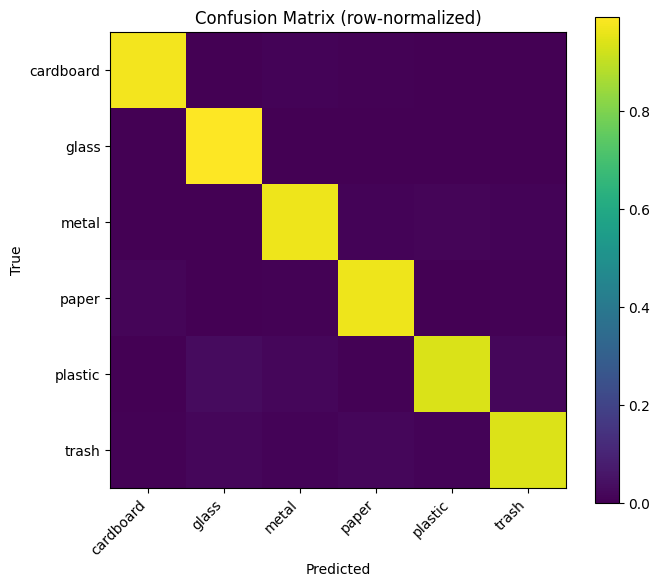


Wrong predictions: 55/1704 (3.23%)

Top confusions (true -> pred):
  plastic -> glass: 7
  paper -> cardboard: 4
  plastic -> trash: 4
  plastic -> metal: 4
  trash -> paper: 4
  trash -> glass: 4
  cardboard -> metal: 3
  metal -> plastic: 3
  cardboard -> paper: 2
  metal -> paper: 2

Top high-confidence wrong predictions:
  idx= 1078  conf=0.967  true=paper  pred=trash  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_paper_161.jpg
  idx= 1321  conf=0.964  true=plastic  pred=glass  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_093.jpg
  idx= 1466  conf=0.926  true=plastic  pred=glass  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_238.jpg
  idx=  474  conf=0.889  true=glass  pred=metal  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_glass_210.jpg
  idx=  211  conf=0.861  true=cardboard  pred=paper  file=C:\Users\jackb\source\repos\Automated_

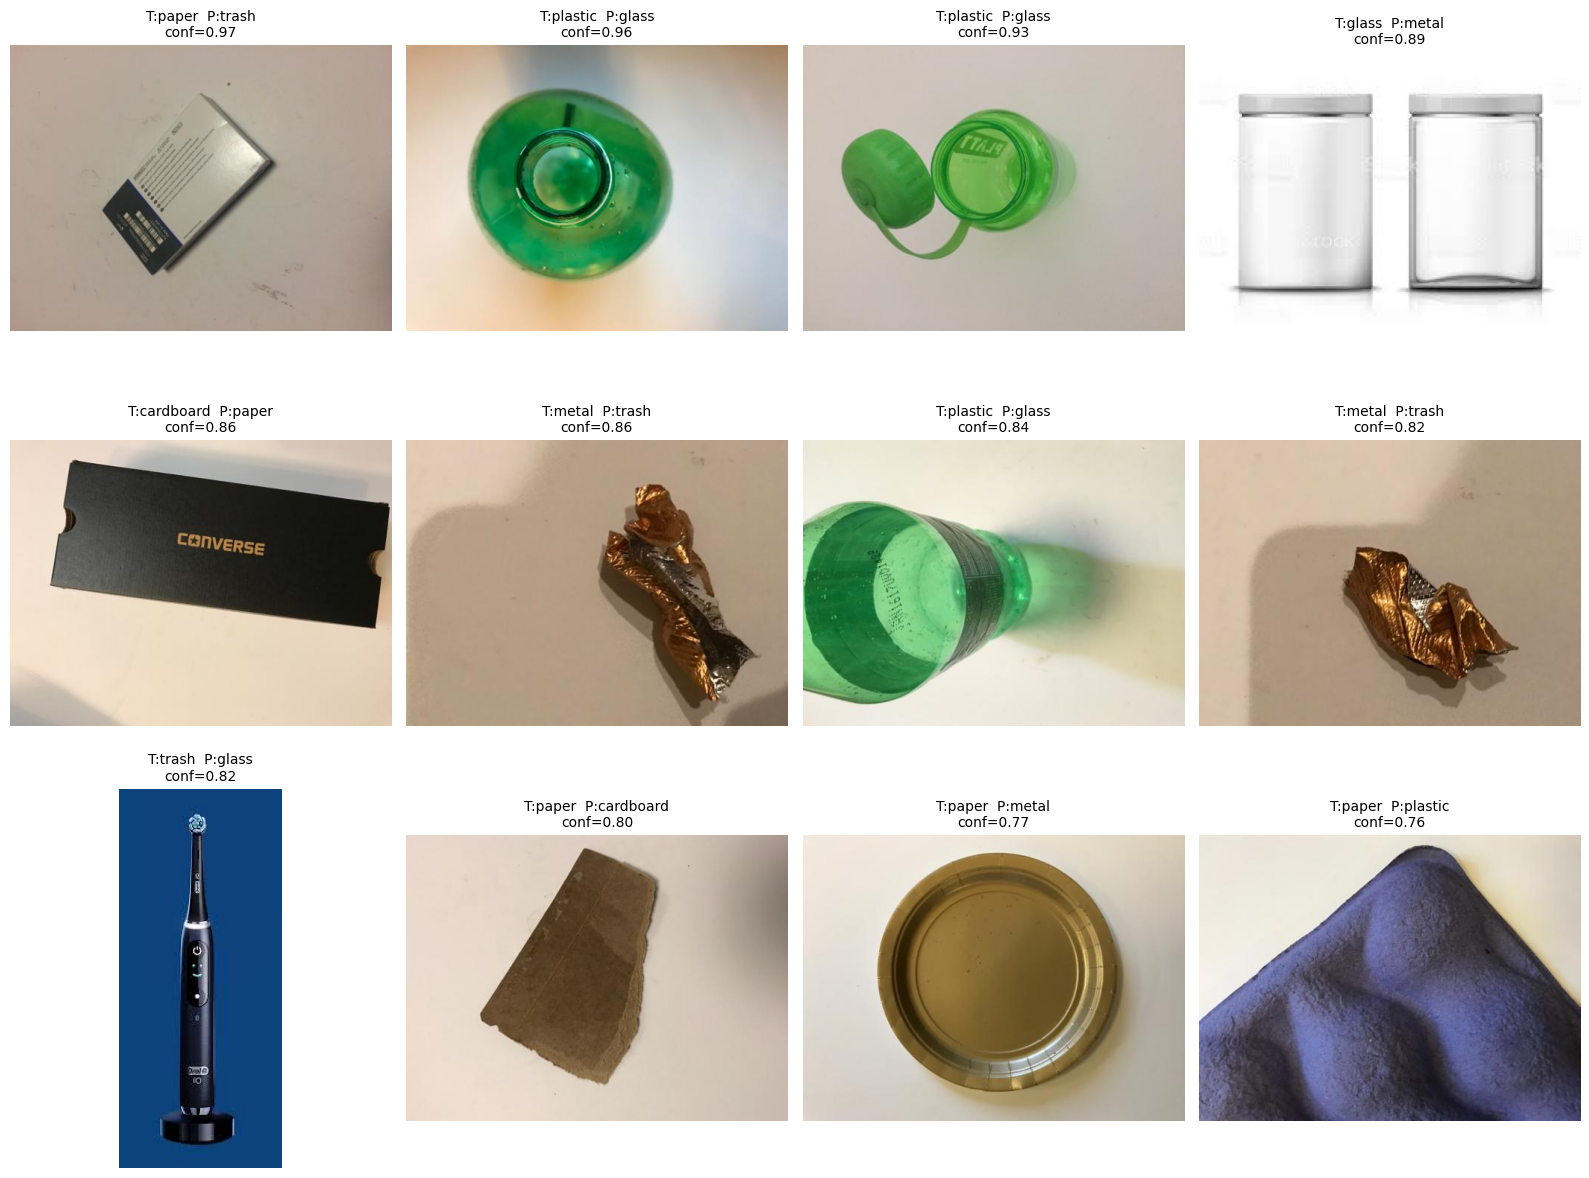


Lowest-confidence correct predictions (potentially ambiguous cases):
  idx= 1288  conf=0.271  class=plastic  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_060.jpg
  idx=   71  conf=0.278  class=cardboard  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_cardboard_071.jpg
  idx= 1608  conf=0.353  class=trash  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_trash_128.jpg
  idx= 1502  conf=0.365  class=trash  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_trash_022.jpg
  idx= 1367  conf=0.433  class=plastic  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_plastic_139.jpg
  idx=  287  conf=0.434  class=glass  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_glass_023.jpg
  idx=  671  conf=0.441  class=glass  file=C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test\test_glass_407.j

In [7]:
# ============================================
# Notebook analysis: load model + error analysis
# ============================================

import os
import math
from collections import Counter, defaultdict

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

import pathlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# If sklearn is available, great; if not, we'll fall back to manual confusion matrix.
try:
    from sklearn.metrics import confusion_matrix, classification_report
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

# ---- your project imports ----
from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset


# -----------------------------
# 0) Config + device
# -----------------------------
cfg = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# 1) Pick checkpoint to analyze
# -----------------------------
CKPT_PATH = "../models/polish_with_ema_best_model.pth"  # <-- change if needed

# -----------------------------
# 2) Build test dataset/loader (choose ONE transform)
#    - Baseline (warped square): Resize((256,256)) then CenterCrop(224)
#    - Or your standard: Resize(256) -> CenterCrop(224)
# Note: batching requires fixed output sizes. The below always outputs 224x224 tensors.
# -----------------------------
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),  # <-- fixed H,W
    transforms.ToTensor(),
    transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
])

data_manager = DataManager()
data_manager.extract_dataset()

test_files = data_manager.get_test_images_list()
classes = data_manager.get_classes_list()
class_to_idx = data_manager.get_class_index_map()
idx_to_class = {v: k for k, v in class_to_idx.items()}

test_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

test_dataset = MaterialDataset(
    files=test_files,
    transform=transform_test,
    classes=classes,
    class_to_idx=class_to_idx,
    labels=test_labels
)

# For Windows notebooks, num_workers=0 is the most stable for analysis
test_loader = DataLoader(
    test_dataset,
    batch_size=getattr(cfg, "batch_size_test", 128),
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

print("Test samples:", len(test_dataset))
print("Classes:", classes)

# -----------------------------
# 3) Rebuild model arch (must match training)
# -----------------------------
num_classes = len(classes)
model = models.resnet50(weights=None)  # weights don't matter when loading your checkpoint
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes),
)
model = model.to(device)

# -----------------------------
# 4) Load checkpoint
# -----------------------------
ckpt = torch.load(CKPT_PATH, map_location=device)
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()

print("Loaded:", CKPT_PATH)

# -----------------------------
# 5) Run inference (collect preds, probs, paths)
# -----------------------------
@torch.no_grad()
def predict_all_flip_tta(model, loader, device):
    y_true, y_pred, y_prob = [], [], []

    for batch in loader:
        imgs, labels = batch[0], batch[1]
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = (model(imgs) + model(torch.flip(imgs, dims=[3]))) / 2.0
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())
        y_prob.append(probs.cpu().numpy())

    return (
        np.concatenate(y_true),
        np.concatenate(y_pred),
        np.concatenate(y_prob),
        getattr(loader.dataset, "files", None),
    )


y_true, y_pred, y_prob, paths = predict_all_flip_tta(model, test_loader, device)

acc = (y_true == y_pred).mean()
print(f"Test accuracy: {acc:.4f}")

# -----------------------------
# 6) Confusion matrix + per-class accuracy
# -----------------------------
def compute_confusion(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes))) if SKLEARN_OK else compute_confusion(y_true, y_pred, num_classes)

per_class_total = cm.sum(axis=1)
per_class_correct = np.diag(cm)
per_class_acc = np.divide(per_class_correct, np.maximum(1, per_class_total))

print("\nPer-class accuracy:")
for i, name in enumerate(classes):
    print(f"  {name:>12s}: {per_class_acc[i]:.4f}  (n={per_class_total[i]})")

if SKLEARN_OK:
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Plot confusion matrix (normalized)
cm_norm = cm.astype(np.float32) / np.maximum(1, cm.sum(axis=1, keepdims=True))
plt.figure(figsize=(7, 6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, classes, rotation=45, ha="right")
plt.yticks(ticks, classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Inspect what it got wrong
#    - Show top confusions
#    - Show hardest mistakes (high confidence wrong)
# -----------------------------
wrong = np.where(y_true != y_pred)[0]
print(f"\nWrong predictions: {len(wrong)}/{len(y_true)} ({len(wrong)/len(y_true):.2%})")

# Top confusions by count
pairs = Counter((int(y_true[i]), int(y_pred[i])) for i in wrong)
print("\nTop confusions (true -> pred):")
for (t, p), c in pairs.most_common(10):
    print(f"  {classes[t]} -> {classes[p]}: {c}")

# Hardest mistakes: highest predicted probability for the wrong class
# score = prob of predicted class
wrong_scores = [(i, float(y_prob[i, y_pred[i]])) for i in wrong]
wrong_scores.sort(key=lambda x: x[1], reverse=True)

print("\nTop high-confidence wrong predictions:")
for i, s in wrong_scores[:10]:
    t = int(y_true[i]); p = int(y_pred[i])
    print(f"  idx={i:5d}  conf={s:.3f}  true={classes[t]}  pred={classes[p]}  file={paths[i] if paths else 'N/A'}")

# -----------------------------
# 8) Visualize a grid of mistakes (requires access to original images)
#    We'll re-load images from disk using their file paths.
#    If your dataset paths are relative, adjust base_dir.
# -----------------------------
from PIL import Image

# Try to locate files: if your paths are already absolute, this is fine.
# If they are relative, set BASE_DIR accordingly.
BASE_DIR = None  # e.g. Path(os.getenv("PROJECT_DIR")) or Path("..")

def load_pil(path):
    p = Path(path) if BASE_DIR is None else (Path(BASE_DIR) / path)
    img = Image.open(p).convert("RGB")
    return img

def show_mistakes(n=12):
    if paths is None:
        print("Dataset doesn't expose file paths (dataset.files missing).")
        return
    if len(wrong_scores) == 0:
        print("No mistakes to show 🎉")
        return

    n = min(n, len(wrong_scores))
    cols = 4
    rows = math.ceil(n / cols)

    plt.figure(figsize=(4*cols, 4*rows))
    for k in range(n):
        i, conf = wrong_scores[k]
        t = int(y_true[i]); p = int(y_pred[i])
        img = load_pil(paths[i])

        plt.subplot(rows, cols, k+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{classes[t]}  P:{classes[p]}\nconf={conf:.2f}", fontsize=10)
    plt.tight_layout()
    plt.show()

show_mistakes(n=12)

# -----------------------------
# 9) (Optional) What’s “most ambiguous” even when correct?
#    Look at lowest confidence correct predictions.
# -----------------------------
correct = np.where(y_true == y_pred)[0]
correct_scores = [(i, float(y_prob[i, y_pred[i]])) for i in correct]
correct_scores.sort(key=lambda x: x[1])  # lowest confidence first

print("\nLowest-confidence correct predictions (potentially ambiguous cases):")
for i, s in correct_scores[:10]:
    t = int(y_true[i])
    print(f"  idx={i:5d}  conf={s:.3f}  class={classes[t]}  file={paths[i] if paths else 'N/A'}")


In [31]:
# -----------------------------
# 10) Confidence vs accuracy buckets + threshold sweep
# -----------------------------
import numpy as np

def confidence_bucket_report(y_true, y_pred, y_prob, bins=None):
    """
    Prints accuracy within confidence buckets.
    Confidence = max probability of the predicted class.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)

    conf = y_prob[np.arange(len(y_pred)), y_pred]
    correct = (y_true == y_pred)

    if bins is None:
        bins = [0.0, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.0]


    print("\nConfidence bucket report:")
    for lo, hi in zip(bins[:-1], bins[1:]):
        m = (conf >= lo) & (conf < hi) if hi < 1.0 else (conf >= lo) & (conf <= hi)
        n = int(m.sum())
        if n == 0:
            print(f"  [{lo:.2f}, {hi:.2f}]: n=0")
            continue
        acc = float(correct[m].mean())
        print(f"  [{lo:.2f}, {hi:.2f}]: n={n:4d}  acc={acc:.4f}  err={1-acc:.4f}")

def threshold_sweep(y_true, y_pred, y_prob, thresholds=None, target_trigger_max=0.15, target_acc_above=0.98):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)

    conf = y_prob[np.arange(len(y_pred)), y_pred]
    correct = (y_true == y_pred)
    wrong = ~correct
    total_wrong = int(wrong.sum())

    if thresholds is None:
        thresholds = np.round(np.linspace(0.50, 0.95, 10), 2)

    rows = []
    for thr in thresholds:
        above = conf >= thr
        below = ~above

        triggered = float(below.mean())
        coverage = float(above.mean())

        acc_above = float(correct[above].mean()) if above.any() else float("nan")
        acc_below = float(correct[below].mean()) if below.any() else float("nan")

        # New: fraction of all errors that fall into the triggered set
        errors_captured = float((wrong & below).sum() / max(1, total_wrong))

        rows.append((thr, coverage, triggered, acc_above, acc_below, int(below.sum()), errors_captured))

    print("\nThreshold sweep (Ollama triggers when conf < threshold):")
    print("  thr   coverage  triggered  acc>=thr    acc<thr   n_trig  errors_captured")
    for thr, cov, trig, acc_a, acc_b, n_trig, err_cap in rows:
        print(f"  {thr:0.2f}   {cov:0.3f}     {trig:0.3f}    {acc_a:0.4f}   {acc_b:0.4f}   {n_trig:4d}      {err_cap:0.3f}")

    candidates = [r for r in rows if r[2] <= target_trigger_max and r[3] >= target_acc_above]
    if candidates:
        best = sorted(candidates, key=lambda r: r[0], reverse=True)[0]
        thr, cov, trig, acc_a, acc_b, n_trig, err_cap = best
        print(f"\nSuggested threshold: {thr:.2f} (triggers {trig:.1%}={n_trig}, high-conf acc={acc_a:.4f}, captures {err_cap:.1%} of errors)")
    else:
        best = sorted(rows, key=lambda r: abs(r[2] - target_trigger_max))[0]
        thr, cov, trig, acc_a, acc_b, n_trig, err_cap = best
        print(f"\nClosest trigger-rate option: thr={thr:.2f} (triggers {trig:.1%}={n_trig}, high-conf acc={acc_a:.4f}, captures {err_cap:.1%} of errors)")

    return rows


# ---- Run it on your existing arrays ----
confidence_bucket_report(y_true, y_pred, y_prob)
threshold_sweep(
    y_true, y_pred, y_prob,
    thresholds=np.round(np.linspace(0.50, 0.95, 10), 2),
    target_trigger_max=0.15,   # aim: send at most 15% to Ollama
    target_acc_above=0.98      # aim: high-conf predictions are very trustworthy
)



Confidence bucket report:
  [0.00, 0.50]: n=  13  acc=0.2308  err=0.7692
  [0.50, 0.60]: n=  23  acc=0.6957  err=0.3043
  [0.60, 0.70]: n=  21  acc=0.5714  err=0.4286
  [0.70, 0.80]: n=  35  acc=0.7714  err=0.2286
  [0.80, 0.90]: n=  60  acc=0.8500  err=0.1500
  [0.90, 0.95]: n=  78  acc=0.9615  err=0.0385
  [0.95, 0.99]: n=1215  acc=0.9942  err=0.0058
  [0.99, 1.00]: n= 259  acc=1.0000  err=0.0000

Threshold sweep (Ollama triggers when conf < threshold):
  thr   coverage  triggered  acc>=thr    acc<thr   n_trig  errors_captured
  0.50   0.992     0.008    0.9746   0.2308     13      0.189
  0.55   0.987     0.013    0.9756   0.4545     22      0.226
  0.60   0.979     0.021    0.9784   0.5278     36      0.321
  0.65   0.973     0.027    0.9795   0.5870     46      0.358
  0.70   0.967     0.033    0.9836   0.5439     57      0.491
  0.75   0.957     0.043    0.9853   0.6027     73      0.547
  0.80   0.946     0.054    0.9882   0.6304     92      0.642
  0.85   0.934     0.066    0.

[(np.float64(0.5),
  0.9923708920187794,
  0.007629107981220657,
  0.9745712596096984,
  0.23076923076923078,
  13,
  0.18867924528301888),
 (np.float64(0.55),
  0.9870892018779343,
  0.012910798122065728,
  0.9756242568370987,
  0.45454545454545453,
  22,
  0.22641509433962265),
 (np.float64(0.6),
  0.9788732394366197,
  0.02112676056338028,
  0.9784172661870504,
  0.5277777777777778,
  36,
  0.32075471698113206),
 (np.float64(0.65),
  0.9730046948356808,
  0.02699530516431925,
  0.9794933655006032,
  0.5869565217391305,
  46,
  0.3584905660377358),
 (np.float64(0.7),
  0.9665492957746479,
  0.03345070422535211,
  0.9836065573770492,
  0.543859649122807,
  57,
  0.49056603773584906),
 (np.float64(0.75),
  0.9571596244131455,
  0.04284037558685446,
  0.9852851011649295,
  0.6027397260273972,
  73,
  0.5471698113207547),
 (np.float64(0.8),
  0.9460093896713615,
  0.0539906103286385,
  0.9882133995037221,
  0.6304347826086957,
  92,
  0.6415094339622641),
 (np.float64(0.85),
  0.93368544

In [32]:
import subprocess

OLLAMA_EXE = r"C:/Users/jackb/AppData/Local/Programs/Ollama/ollama.exe"  # <-- paste from where.exe
print(subprocess.run([OLLAMA_EXE, "list"], capture_output=True, text=True).stdout)


NAME            ID              SIZE      MODIFIED       
llava:latest    8dd30f6b0cb1    4.7 GB    45 minutes ago    



In [33]:
import json, base64
from pathlib import Path
from urllib import request, error

OLLAMA_HOST = "http://localhost:11434"
TIMEOUT_S = 120

def call_ollama_pick_from_options_http(image_path: str, options: list[str], model_name: str) -> str:
    prompt = (
        "You are classifying a recycling image.\n"
        f"Choose exactly ONE label from: {', '.join(options)}.\n"
        "Respond with only the label text, nothing else.\n"
    )

    img_b64 = base64.b64encode(Path(image_path).read_bytes()).decode("utf-8")

    payload = {
        "model": model_name,
        "messages": [
            {"role": "user", "content": prompt, "images": [img_b64]}
        ],
        "stream": False,
        "options": {"temperature": 0.0}
    }

    url = f"{OLLAMA_HOST}/api/chat"
    data = json.dumps(payload).encode("utf-8")
    req = request.Request(url, data=data, headers={"Content-Type": "application/json"})

    try:
        with request.urlopen(req, timeout=TIMEOUT_S) as resp:
            out = json.loads(resp.read().decode("utf-8"))
    except error.HTTPError as e:
        raise RuntimeError(f"Ollama HTTPError {e.code}: {e.read().decode('utf-8', errors='ignore')}")

    text = out["message"]["content"].strip().lower().replace(".", "").replace('"', "").replace("'", "").strip()

    if text in options:
        return text

    # fallback: find an option token inside output
    for c in options:
        if c in text:
            return c

    return "unknown"


In [34]:
# ============================================================
# Ollama-gated eval (only low-confidence samples)
# - Uses your existing y_true/y_pred/y_prob/paths from predict_all
# - Calls Ollama only when conf < THRESH
# - Caches results to JSON so you don't re-run calls
# - Reports ResNet vs Hybrid accuracy + flips helped/hurt
# ============================================================

import json
import base64
import subprocess
from pathlib import Path
import numpy as np

# ----------------------------
# Settings
# ----------------------------
THRESH = 0.75
OLLAMA_MODEL = "llava:latest"  # <-- CHANGE to your installed vision model name (check `ollama list`)
CACHE_PATH = Path("ollama_cache_eval.json")

# Your class list (must match training)
# classes = ['cardboard','glass','metal','paper','plastic','trash']

# ----------------------------
# Helpers
# ----------------------------
def load_cache(path: Path):
    if path.exists():
        return json.loads(path.read_text(encoding="utf-8"))
    return {}

def save_cache(path: Path, cache: dict):
    path.write_text(json.dumps(cache, indent=2), encoding="utf-8")

def image_to_b64(path: str) -> str:
    data = Path(path).read_bytes()
    return base64.b64encode(data).decode("utf-8")

def get_confidence(y_pred, y_prob):
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)
    conf = y_prob[np.arange(len(y_pred)), y_pred]
    return conf

# ----------------------------
# Gate + evaluate
# ----------------------------
cache = load_cache(CACHE_PATH)

y_true_np = np.asarray(y_true)
y_pred_np = np.asarray(y_pred)
conf_np = get_confidence(y_pred_np, y_prob)

assert paths is not None, "Need file paths (dataset.files) to call Ollama on images."

trigger_idx = np.where(conf_np < THRESH)[0]
print(f"Threshold={THRESH:.2f} triggers {len(trigger_idx)}/{len(y_true_np)} ({len(trigger_idx)/len(y_true_np):.1%}) Ollama calls (before cache).")

# Hybrid preds start as ResNet preds
hybrid_pred = y_pred_np.copy()

# Track stats
n_called = 0
n_cached = 0
n_unknown = 0

from tqdm import tqdm
import time

start_time = time.time()

THRESH = 0.75
TOPK = 2
OVERRIDE_MAX_CONF = 0.65

hybrid_pred = y_pred_np.copy()
conf_np = y_prob[np.arange(len(y_pred_np)), y_pred_np]

for i in tqdm(trigger_idx, desc="Ollama eval (top2 + conservative)", unit="img"):
    img_path = str(paths[i])

    # Top-2 candidates from ResNet
    top_idx = np.argsort(-y_prob[i])[:TOPK]
    options = [classes[j] for j in top_idx]

    key = f"{OLLAMA_MODEL}|{img_path}|opts={','.join(options)}"
    if key in cache:
        pred_label = cache[key]["label"]
        n_cached += 1
    else:
        pred_label = call_ollama_pick_from_options_http(img_path, options, OLLAMA_MODEL)
        cache[key] = {"label": pred_label, "threshold": float(THRESH), "options": options}
        n_called += 1

    if pred_label == "unknown":
        n_unknown += 1
        continue

    # Only override when ResNet is VERY unsure
    if conf_np[i] < OVERRIDE_MAX_CONF:
        hybrid_pred[i] = classes.index(pred_label)

# Optional: save cache at the end (safe even if already saved)
save_cache(CACHE_PATH, cache)

elapsed = time.time() - start_time
print(f"\nOllama eval finished in {elapsed/60:.1f} minutes "
      f"({elapsed/len(trigger_idx):.2f}s per image)")

# ----------------------------
# Report results
# ----------------------------
resnet_acc = float((y_true_np == y_pred_np).mean())
hybrid_acc = float((y_true_np == hybrid_pred).mean())

print("\n--- Results ---")
print(f"ResNet acc:  {resnet_acc:.4f}")
print(f"Hybrid acc:  {hybrid_acc:.4f}")
print(f"Ollama model: {OLLAMA_MODEL}")
print(f"Triggered:   {len(trigger_idx)} samples")
print(f"New calls:   {n_called}  | From cache: {n_cached}  | unknown outputs: {n_unknown}")
print(f"Cache file:  {CACHE_PATH.resolve()}")

# Flip analysis: did Ollama help?
changed = np.where(hybrid_pred != y_pred_np)[0]
helped = np.where((y_true_np == hybrid_pred) & (y_true_np != y_pred_np))[0]
hurt   = np.where((y_true_np != hybrid_pred) & (y_true_np == y_pred_np))[0]

print("\n--- Flip analysis ---")
print(f"Changed predictions: {len(changed)}")
print(f"Helped:              {len(helped)}")
print(f"Hurt:                {len(hurt)}")

# Optional: show which classes Ollama tends to change into (on triggered set)
from collections import Counter
c_from = Counter(classes[int(y_pred_np[i])] for i in changed)
c_to   = Counter(classes[int(hybrid_pred[i])] for i in changed)
print("\nTop changes FROM (ResNet):", c_from.most_common(6))
print("Top changes TO (Ollama):  ", c_to.most_common(6))


Threshold=0.75 triggers 73/1704 (4.3%) Ollama calls (before cache).


Ollama eval (top2 + conservative): 100%|██████████| 73/73 [01:58<00:00,  1.62s/img]


Ollama eval finished in 2.0 minutes (1.62s per image)

--- Results ---
ResNet acc:  0.9689
Hybrid acc:  0.9718
Ollama model: llava:latest
Triggered:   73 samples
New calls:   44  | From cache: 29  | unknown outputs: 0
Cache file:  C:\Users\jackb\source\repos\Automated_Material_Recognition\src\ollama_cache_eval.json

--- Flip analysis ---
Changed predictions: 19
Helped:              11
Hurt:                6

Top changes FROM (ResNet): [('paper', 6), ('metal', 6), ('glass', 4), ('plastic', 3)]
Top changes TO (Ollama):   [('trash', 8), ('glass', 5), ('cardboard', 2), ('plastic', 2), ('paper', 2)]
